## Publishing rate analyzer [Fake data]

This notebook is a proof of concept for the real data analysis. It uses generated data in place of the real data used in the 2017 study: [The Research Productivity of New PhDs in Economics: The Surprisingly High Non-success of the Successful](https://www.aeaweb.org/articles?id=10.1257/jep.28.3.205).

The proof of concept is a mental baseline for myself before doing the real analysis.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import theano.tensor as tt
import pymc3 as pm
import arviz as az

sns.set_palette("husl")

In [7]:
fake_data = pd.read_csv("fake_data/fake_data.csv")
fake_data.head()

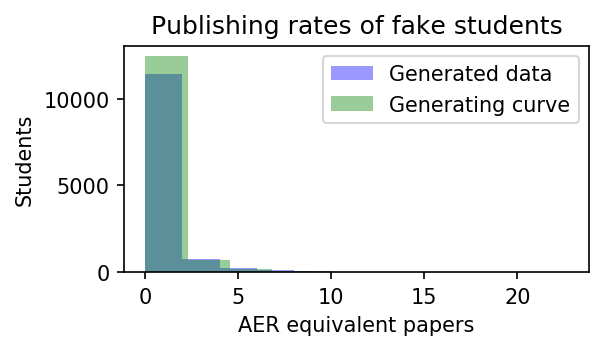

In [58]:
fig, ax = plt.subplots(figsize=(4,2))
fig.set_dpi(150)
ax.hist(fake_data.AERPub, color = "blue", alpha=0.4, label = "Generated data");
ax.hist(np.random.gamma(shape=0.2, scale=3, size=900*15), color="green", alpha=0.4, label="Generating curve");
ax.set(title="Publishing rates of fake students", xlabel="AER equivalent papers", ylabel="Students");
ax.legend();

In [72]:
with pm.Model() as fake_model:
    shape = pm.Uniform("shape", lower=0, upper=2)
    scale = pm.Uniform("scale", lower=0, upper=5)
    gamma = pm.Gamma("liklihood", alpha = shape, beta = scale, observed = fake_data.AERPub)
    
    inf_data = pm.sample(draws = 2000, tune=1000, cores=4, chains=4, step=pm.NUTS(), return_inferencedata=True)
#     trace = pm.sample(draws=2000, tune=1000, cores=4, chains=4)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scale, shape]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8802214524927374, but should be close to 0.8. Try to increase the number of tuning steps.


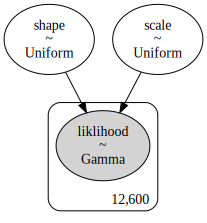

In [60]:
pm.model_to_graphviz(fake_model)

In [61]:
print("Free variables: ", fake_model.free_RVs)
print("Observed variables: ", fake_model.observed_RVs)

Free variables:  [shape_interval__, scale_interval__]
Observed variables:  [liklihood]


In [67]:
inf_data.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    shape    (chain, draw) float64 0.1994 0.1994 0.202 ... 0.2002 0.1978 0.1978
    scale    (chain, draw) float64 0.3338 0.3338 0.3323 ... 0.331 0.3252 0.3252
Attributes:
    created_at:                 2020-09-02T14:18:39.888267
    arviz_version:              0.9.0
    inference_library:          pymc3
    inference_library_version:  3.9.3
    sampling_time:              24.514123916625977
    tuning_steps:               1000

In [63]:
inf_data.posterior.shape

<xarray.DataArray 'shape' (chain: 4, draw: 2000)>
array([[0.19937539, 0.19937539, 0.20204886, ..., 0.1984426 , 0.19889675,
        0.20003188],
       [0.19917889, 0.19797113, 0.19974225, ..., 0.1986224 , 0.19713722,
        0.19924669],
       [0.20180622, 0.20212689, 0.19875302, ..., 0.19947808, 0.20093947,
        0.20088861],
       [0.20221176, 0.20135526, 0.20006828, ..., 0.20015502, 0.1978494 ,
        0.1978494 ]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

In [69]:
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
shape,0.20,0.002,0.197,0.204,0.0,0.0,5162.0,5162.0,5145.0,4933.0,1.0
scale,0.33,0.007,0.316,0.344,0.0,0.0,5322.0,5315.0,5325.0,5381.0,1.0


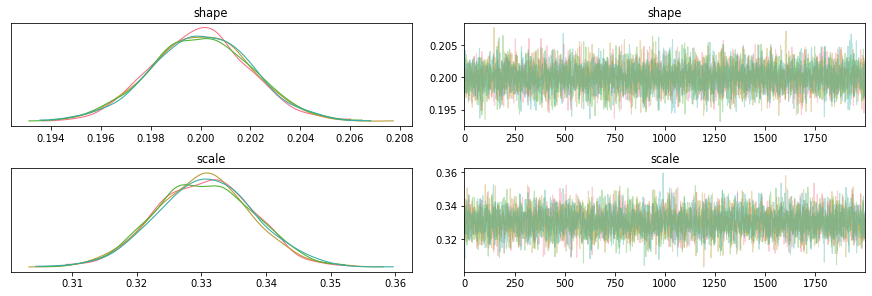

In [34]:
# The shape is correct, but the scale may be off here. Confirm.
az.plot_trace(inf_data);

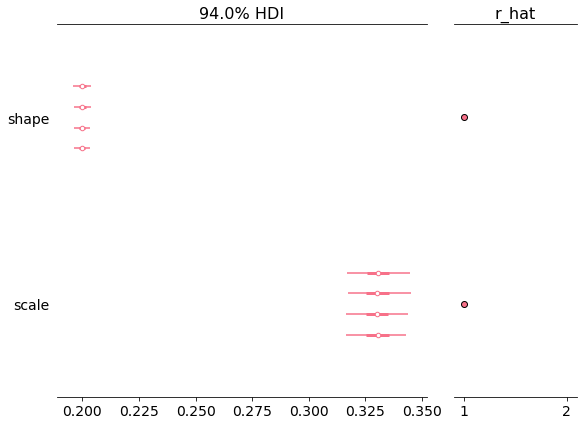

In [36]:
az.plot_forest(inf_data, r_hat=True);

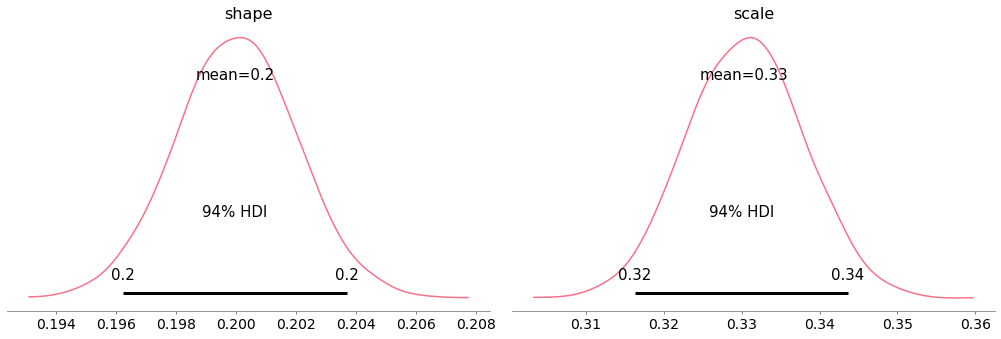

In [38]:
az.plot_posterior(inf_data);

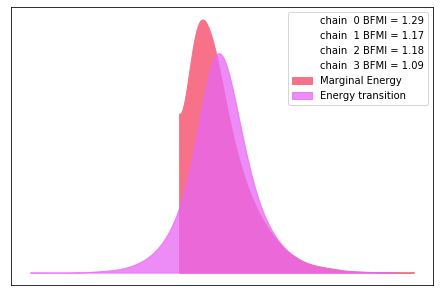

In [41]:
# TODO - look up energy plot interpretation
az.plot_energy(inf_data);

In [78]:
with fake_model:
    posterior_predictions_dict = pm.sample_posterior_predictive(inf_data.posterior)    

In [87]:
combined_inf_data = az.concat(inf_data, az.from_pymc3(posterior_predictive=posterior_predictions_dict), inplace=False)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

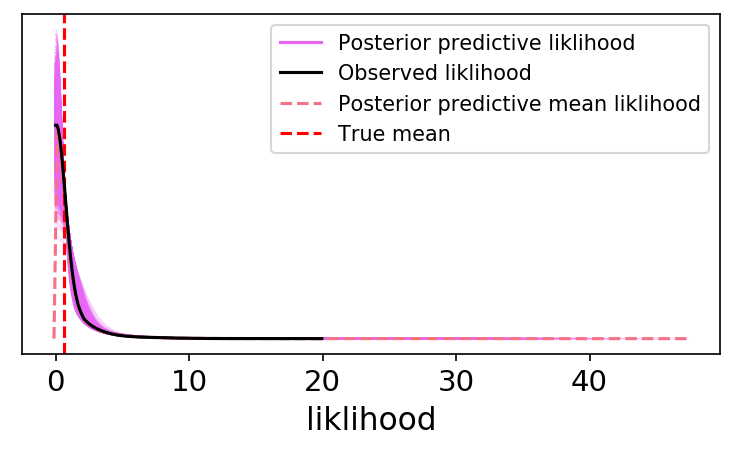

In [91]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_dpi(150)
az.plot_ppc(combined_inf_data, ax=ax)
ax.axvline(fake_data.AERPub.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

# Multi level model

Now we'll follow along [this tutorial](https://docs.pymc.io/notebooks/multilevel_modeling.html) to build a MLM and get better at understanding the  details.

In [3]:
# Import radon data
srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

In [4]:
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county
5080,5081,MN,MN,27,55735,5,1,1,3,N,...,930,12088,12288,2.2,9.7,1146.499190,1,0,1,AITKIN
5081,5082,MN,MN,27,55748,5,1,0,4,Y,...,1615,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN
5082,5083,MN,MN,27,55748,5,1,0,4,Y,...,1515,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN
5083,5084,MN,MN,27,56469,5,1,0,4,Y,...,1410,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN
5084,5085,MN,MN,27,55011,3,1,0,4,Y,...,600,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA


In [12]:
srrs_mn.describe()

,idnum,stfips,region,typebldg,floor,room,stratum,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,fips,Uppm
count,919.000000,919.0,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000
mean,5540.000000,27.0,3.119695,1.039173,0.166485,3.285092,3.171926,1413.824810,1420.341676,58827.323177,57139.746464,4.768118,10.481719,1051.681933,0.085963,0.001088,87.413493,27087.413493,0.933912
std,265.436747,0.0,1.303102,0.453250,0.372719,1.624065,1.128380,483.270698,508.209828,51281.333735,50830.218730,4.481584,8.477540,595.841532,0.340141,0.032987,52.126239,52.126239,0.320094
min,5081.000000,27.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,10188.000000,10188.000000,0.000000,0.000000,348.042925,0.000000,0.000000,1.000000,27001.000000,0.414025
25%,5310.500000,27.0,2.000000,1.000000,0.000000,2.000000,2.000000,1000.000000,1000.000000,12688.000000,12638.000000,1.900000,5.200000,471.366223,0.000000,0.000000,41.000000,27041.000000,0.622088
50%,5540.000000,27.0,3.000000,1.000000,0.000000,4.000000,3.000000,1415.000000,1420.000000,22488.000000,22588.000000,3.600000,8.100000,990.411554,0.000000,0.000000,85.000000,27085.000000,0.907991
75%,5769.500000,27.0,4.000000,1.000000,0.000000,4.000000,4.000000,1817.500000,1835.500000,121687.000000,121787.000000,6.000000,12.700000,1146.499190,0.000000,0.000000,137.000000,27137.000000,1.201100
max,5999.000000,27.0,5.000000,5.000000,1.000000,7.000000,5.000000,2337.000000,2355.000000,123187.000000,123187.000000,48.200000,66.300000,2314.365189,2.000000,1.000000,173.000000,27173.000000,1.695580


In [5]:
# Obtain county level predictor: uranium, by combining stfips and cntyfips?
srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty = pd.read_csv(pm.get_data("cty.dat"))
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

In [7]:
cty.head()

,stfips,ctfips,st,cty,lon,lat,Uppm
0,1,1,AL,AUTAUGA,-86.643,32.534,1.78331
1,1,3,AL,BALDWIN,-87.750,30.661,1.38323
2,1,5,AL,BARBOUR,-85.393,31.870,2.10105
3,1,7,AL,BIBB,-87.126,32.998,1.67313
4,1,9,AL,BLOUNT,-86.568,33.981,1.88501


In [8]:
# Combine home level and conty level info into one df
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [11]:
srrs_mn.describe()

,idnum,stfips,region,typebldg,floor,room,stratum,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,fips,Uppm
count,919.000000,919.0,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000
mean,5540.000000,27.0,3.119695,1.039173,0.166485,3.285092,3.171926,1413.824810,1420.341676,58827.323177,57139.746464,4.768118,10.481719,1051.681933,0.085963,0.001088,87.413493,27087.413493,0.933912
std,265.436747,0.0,1.303102,0.453250,0.372719,1.624065,1.128380,483.270698,508.209828,51281.333735,50830.218730,4.481584,8.477540,595.841532,0.340141,0.032987,52.126239,52.126239,0.320094
min,5081.000000,27.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,10188.000000,10188.000000,0.000000,0.000000,348.042925,0.000000,0.000000,1.000000,27001.000000,0.414025
25%,5310.500000,27.0,2.000000,1.000000,0.000000,2.000000,2.000000,1000.000000,1000.000000,12688.000000,12638.000000,1.900000,5.200000,471.366223,0.000000,0.000000,41.000000,27041.000000,0.622088
50%,5540.000000,27.0,3.000000,1.000000,0.000000,4.000000,3.000000,1415.000000,1420.000000,22488.000000,22588.000000,3.600000,8.100000,990.411554,0.000000,0.000000,85.000000,27085.000000,0.907991
75%,5769.500000,27.0,4.000000,1.000000,0.000000,4.000000,4.000000,1817.500000,1835.500000,121687.000000,121787.000000,6.000000,12.700000,1146.499190,0.000000,0.000000,137.000000,27137.000000,1.201100
max,5999.000000,27.0,5.000000,5.000000,1.000000,7.000000,5.000000,2337.000000,2355.000000,123187.000000,123187.000000,48.200000,66.300000,2314.365189,2.000000,1.000000,173.000000,27173.000000,1.695580


In [13]:
# Create a lookup table of unique counties for indexing
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))

In [17]:
# Create local copies of those variables
county = srrs_mn["county_code"] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

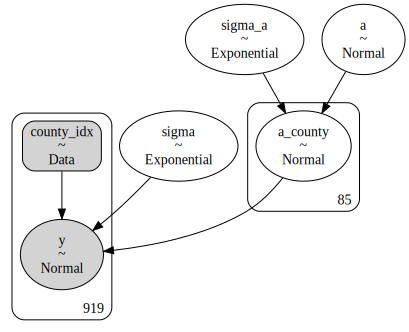

In [30]:
# Multi level model magic: partial pooling
coords = {"Level": ["Basement", "Floor"], "obs_id": np.arange(floor.size), "County": mn_counties}
with pm.Model(coords=coords) as partial_pooling:
    county_idx = pm.Data("county_idx", county, dims="obs_id")
    # Hyperpriors:
    a = pm.Normal("a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)

    # Varying intercepts:
    a_county = pm.Normal("a_county", mu=a, sigma=sigma_a, dims="County")

    # Expected value per county:
    theta = a_county[county_idx]
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")
pm.model_to_graphviz(partial_pooling)

In [32]:
with partial_pooling:
    partial_pooling_idata = pm.sample(tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a_county, sigma_a, a]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [34]:
# Adding in the no-pooling model to compare with the partial pooling (mlm)
with pm.Model(coords=coords) as unpooled_bis:
    county_idx = pm.Data("county_idx", county, dims="obs_id")
    a_county = pm.Normal("a_county", 0.0, sigma=10.0, dims="County")

    theta = a_county[county_idx]
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

    unpooled_idata_bis = pm.sample(tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a_county]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 16 seconds.


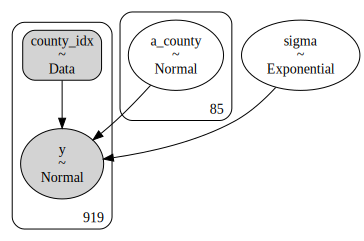

In [37]:
pm.model_to_graphviz(unpooled_bis)

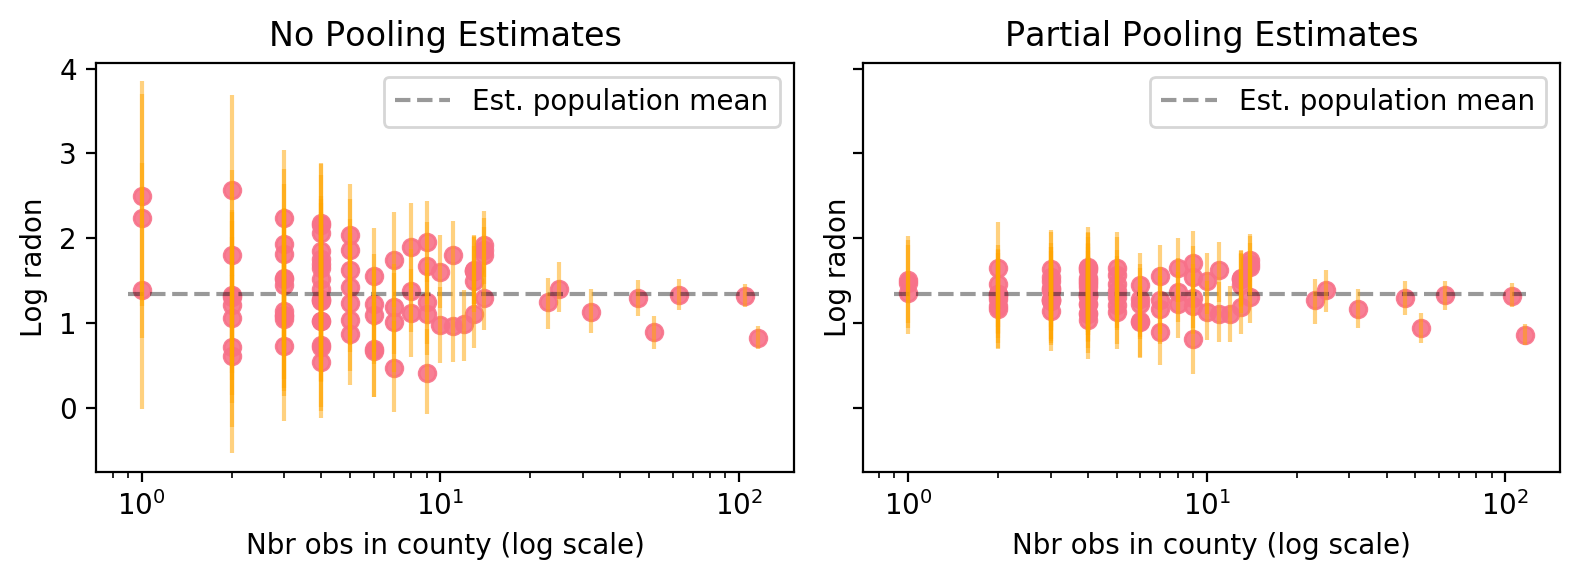

In [36]:
# Compare the two posteriors
N_county = srrs_mn.groupby("county")["idnum"].count().values

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
fig.set_dpi(200)
for ax, idata, level in zip(
    axes,
    (unpooled_idata_bis, partial_pooling_idata),
    ("no pooling", "partial pooling"),
):

    # add variable with x values to xarray dataset
    idata.posterior = idata.posterior.assign_coords({"N_county": ("County", N_county)})
    # plot means
    idata.posterior.mean(dim=("chain", "draw")).plot.scatter(x="N_county", y="a_county", ax=ax, alpha=0.9);
    ax.hlines(
        partial_pooling_idata.posterior.a.mean(),
        0.9,
        max(N_county) + 1,
        alpha=0.4,
        ls="--",
        label="Est. population mean",
    )

    # plot hdi
    hdi = az.hdi(idata).a_county
    ax.vlines(N_county, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color="orange", alpha=0.5)

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Nbr obs in county (log scale)",
        xscale="log",
        ylabel="Log radon",
    )
    ax.legend(fontsize=10)
fig.tight_layout();

In [38]:
N_county = srrs_mn.groupby("county")["idnum"].count().values

In [39]:
N_county

array([  4,  52,   3,   7,   4,   3,  14,   4,  10,   6,   5,   4,   6,
        14,   4,   2,   4,  12,  63,   3,   9,   6,   2,   9,  14, 105,
         6,   5,   3,  11,   5,   4,   4,   3,   7,   2,   9,   4,   5,
         4,   8,   1,   9,   7,  13,   5,   2,   9,  13,   1,   4,   3,
         3,  23,   8,   3,   6,   4,   4,   2,  32,   5,   3,  11,   2,
        14,  13,   8,   4, 116,  25,  10,   2,   4,   3,   4,   7,   5,
         4,  46,   3,   1,  13,  13,   2])

In [41]:
partial_pooling_idata.posterior

<xarray.Dataset>
Dimensions:   (County: 85, chain: 2, draw: 1000)
Coordinates:
  * chain     (chain) int64 0 1
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * County    (County) object 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
    N_county  (County) int64 4 52 3 7 4 3 14 4 10 6 5 ... 4 7 5 4 46 3 1 13 13 2
Data variables:
    a         (chain, draw) float64 1.326 1.333 1.3 1.298 ... 1.42 1.293 1.319
    a_county  (chain, draw, County) float64 0.8458 1.007 1.397 ... 1.617 1.257
    sigma_a   (chain, draw) float64 0.2907 0.3875 0.4173 ... 0.2674 0.3565
    sigma     (chain, draw) float64 0.788 0.7596 0.7657 ... 0.716 0.8226 0.7961
Attributes:
    created_at:                 2020-09-10T14:10:07.136728
    arviz_version:              0.9.0
    inference_library:          pymc3
    inference_library_version:  3.9.3
    sampling_time:              19.957807064056396
    tuning_steps:               2000